<a href="https://colab.research.google.com/github/psanabriaUC/BatteryDatasetImplementation/blob/master/Battery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manual de preparación y uso del modelo de *Deep Learning* para prediccion del SoH de la batería
En este Python Notebook se muestra y se analiza como debe ser tratado el dataset de carga/descarga de baterias obtenido de la NASA. Igualmente se muestra
como se prepara el modelo propuesto por [1] y su encoding realizado

## Requisitos
Para la fase de entrenamiento de este modelo es necesario tener instalado Python 3.x junto a las siguientes librerías:

* Tensorflow 2.0
* Numpy
* Pandas
* Scipy
* Sci-kit learn
* Matplot
* Seaborn

Para la fase de predicción de este modelo es necesario tener las mismas librerías con la excepción a Matplot y Seaborn


## Preparación del dataset
Debido a que este manual se trabajó desde Google Colab (esto puede no ser necesario hacerlo en un entorno offline), es necesario descargar el dataset y después descomprimirlo en un directorio especifico.

In [1]:
%tensorflow_version 2.x
%matplotlib inline
!pip show tensorflow
!wget -cq https://ti.arc.nasa.gov/c/5 -O naza.zip
!unzip -qqo naza.zip -d battery_data

TensorFlow 2.x selected.
Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-2.0.0/python3.6
Requires: numpy, six, google-pasta, tensorboard, absl-py, wrapt, wheel, termcolor, astor, grpcio, protobuf, keras-preprocessing, keras-applications, opt-einsum, tensorflow-estimator, gast
Required-by: stable-baselines, magenta, fancyimpute


## Importación de librerías
En esta parte se important todas las librerías necesarias para el tratamiento del dataset

In [0]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Carga del dataset en memoria
Segun el README del dataset, los datos estan almacenados en varios archivos ".mat", cada archivo corresponde a una batería en concreto y la estructura de los datos de cada archivo es la siguiente (copiado desde el README del dataset):

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)

```

Para el modelo de Deep Learning propuesto en [1] solo es necesario recabar los datos relacionados a la descarga de la bateria, para esto se crea una función en Python que se encarga de leer estos datos del archivo ".mat" y almacenarlo en memoria en dos DataFrame de pandas para su posterior acceso.
Después de la carga del dataset se hace una descripción de los datos usando funciones de panda para verificar si la carga de datos fue correcta.

In [3]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


El siguiente gráfico muestra el proceso de envejecimiento de la bateria a medida que avanzan los ciclos de carga. La linea horizontal representa el threshold relacionado a lo que se puede considerar el fin de ciclo de vida de la batería.

Text(0.5, 1.0, 'Discharge B0005')

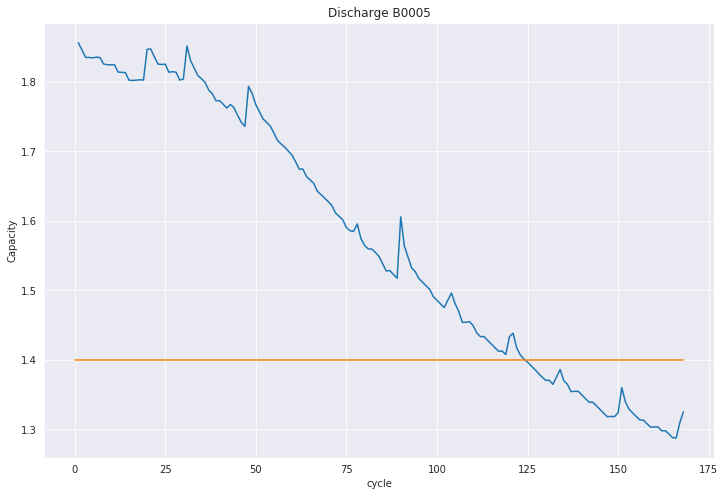

In [4]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

Es necesario igualmente calcular el SoH de la bateria, ya que este es el dato que se va a predecir haciendo uso del modelo de *deep learning*

In [5]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Igualmente a lo hecho anteriormente, se realiza una gráfica del SoH por cada ciclo, la línea horizontal representa el threshold del 70% en el cual la bateria ya cumple su ciclo de vida y ya es recomendable hacer el cambio.

Text(0.5, 1.0, 'Discharge B0005')

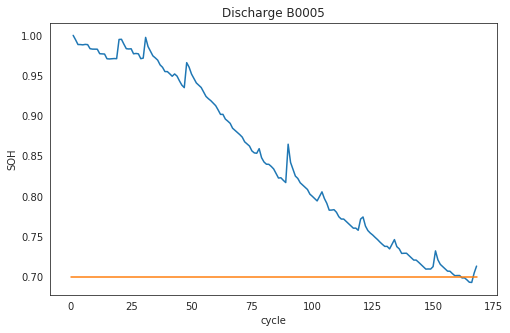

In [6]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

## Fase de entrenamiento


In [7]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [9]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=10)

Train on 50285 samples
Epoch 1/10
50285/50285 [==============================] - 9s 175us/sample - loss: 0.1047
Epoch 2/10
50285/50285 [==============================] - 7s 139us/sample - loss: 0.0229
Epoch 3/10
50285/50285 [==============================] - 7s 139us/sample - loss: 0.0226
Epoch 4/10
50285/50285 [==============================] - 7s 140us/sample - loss: 0.0226
Epoch 5/10
50285/50285 [==============================] - 7s 139us/sample - loss: 0.0224
Epoch 6/10
50285/50285 [==============================] - 7s 141us/sample - loss: 0.0222
Epoch 7/10
50285/50285 [==============================] - 7s 142us/sample - loss: 0.0225
Epoch 8/10
50285/50285 [==============================] - 7s 139us/sample - loss: 0.0222
Epoch 9/10
50285/50285 [==============================] - 7s 141us/sample - loss: 0.0222
Epoch 10/10
50285/50285 [==============================] - 7s 140us/sample - loss: 0.0224


In [12]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

In [13]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)
print(pd.DataFrame(data=soh_pred, columns=['SoH']).head(10))
print(soh_pred[50000:50010])
print(soh.to_numpy()[50000:50010])

(50285, 1)
        SoH
0  0.949567
1  0.936719
2  0.952306
3  0.952880
4  0.953337
5  0.953884
6  0.954410
7  0.954934
8  0.955472
9  0.955933
[[0.73385745]
 [0.73390716]
 [0.7339148 ]
 [0.73393226]
 [0.7339033 ]
 [0.733979  ]
 [0.7340134 ]
 [0.73403484]
 [0.7340675 ]
 [0.7340927 ]]
[[0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]
 [0.71375616]]
